
# Análisis Predictivo de Cambios Cognitivos Basado en Urolitinas

Este notebook realiza un análisis completo sobre la relación entre metabolitos tipo urolitina y cambios en dominios cognitivos, a través de las siguientes etapas:

1. Limpieza y transformación de las variables de urolitinas
2. Cálculo de deltas logarítmicos
3. Imputación y normalización de datos
4. Visualización inicial (histogramas de las variables transformadas)
5. Clasificación multiclase por dominio cognitivo (`mejoró`, `igual`, `empeoró`)
6. Entrenamiento de múltiples clasificadores por metabotipo
7. Evaluación de desempeño (F1 macro)
8. Visualizaciones: matriz de confusión, importancia de variables, comparativas

Todas las etapas están separadas en celdas independientes para facilitar la comprensión y modificación.


### Descripción general del análisis

En este notebook llevamos a cabo un análisis predictivo con el objetivo de estudiar los cambios en los dominios cognitivos de los participantes a partir de sus perfiles metabólicos de urolitinas. Nuestra intención fue identificar si las variaciones en los niveles de estos metabolitos podrían estar asociadas con una mejora, estabilidad o deterioro en la función cognitiva.

El análisis comenzó con la limpieza y transformación de las variables asociadas a urolitinas. Sustituimos valores nulos o atípicos por referencias fundamentadas, y calculamos deltas logarítmicos entre las mediciones de referencia y seguimiento, con el fin de capturar de manera más sensible los cambios en el metabolismo.

Posteriormente, normalizamos los datos y procedimos a entrenar diversos modelos de clasificación multiclase para predecir los tres posibles resultados cognitivos: mejoró, se mantuvo igual o empeoró. Utilizamos métricas como el F1 macro, adecuadas para problemas con clases desbalanceadas, para evaluar el rendimiento de los modelos.

Finalmente, incluimos visualizaciones como matrices de confusión y gráficos de importancia de variables, que nos permitieron interpretar de forma más profunda los resultados obtenidos. El objetivo general fue no solo construir modelos con buen rendimiento, sino también lograr interpretaciones útiles desde el punto de vista clínico y analítico.


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:

# Dataset principal
from google.colab import drive
drive.mount('/content/drive')

import re
from pathlib import Path
data_path = Path('/content/drive/MyDrive/ProyectoIntegrador/WAHA_Urolithins_MetabotypesData.dta')
df = pd.read_stata(data_path)
print('Shape:', df.shape)
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape: (741, 693)


,patient_id,Metabotype_1,Metabotype_2,Age_,high_sensitivity_CRP,high_sensitivity_CRP2,glucose,glucose2,glycated_hb,glycated_hb2,...,TransFatE_v24,TransFatE_Dif,Cholesterolmg_Dif,Phytosterolstotalmg_Dif,Polyphenolstotalmg_Dif,Alcoholg_Dif,GlycemicIndex_Dif,OtherNuts_v0,OtherNuts_v12,OtherNuts_v24
0,1001.0,1.0,1.0,71.0,0.16,0.09,96.0,89.0,5.8,5.7,...,0.158066,0.127286,-52.48,-46.88,241.47,-1.84,-5.821738,0.0,0.000000,0.0
1,1002.0,1.0,1.0,72.0,0.19,0.20,77.0,77.0,5.8,5.7,...,0.069215,-0.030135,-115.67,-46.31,-20.60,0.00,3.084686,0.0,0.000000,0.0
2,1003.0,1.0,1.0,68.0,0.09,0.10,90.0,78.0,6.2,5.9,...,0.136315,-0.139327,212.34,43.80,295.79,0.00,-16.561873,0.0,0.000000,0.0
3,1004.0,0.0,1.0,74.0,NaN,0.08,94.0,100.0,5.9,5.8,...,0.086978,0.029857,6.45,125.66,336.17,0.90,1.990668,0.0,0.000000,0.0
4,1005.0,2.0,1.0,66.0,0.04,0.11,103.0,125.0,6.1,6.1,...,0.115696,-0.036360,113.90,30.82,685.77,-6.80,9.558450,0.0,13.333333,0.0


In [ ]:

replacements = {
    'UroA_1_CQ': 7.67001, 'UroA_2_CQ': 7.67001,
    'UroA_glu_1_CQ': 5.0964, 'UroA_glu_2_CQ': 5.0964,
    'UroB_1_CQ': 3.30322, 'UroB_2_CQ': 3.30322,
    'UroB_glu_1_CQ': 5.798998, 'UroB_glu_2_CQ': 5.798998,
    'UroC_1_CQ': 11.64194, 'UroC_2_CQ': 11.64194,
    'UroC_glu_1_CQ': 11.64194, 'UroC_glu_2_CQ': 11.64194
}
for col, val in replacements.items():
    df[col] = df[col].replace(0, val)


In [ ]:

delta_pairs = [(col, col.replace("1_CQ", "2_CQ")) for col in df.columns if "_1_CQ" in col and col.replace("1_CQ", "2_CQ") in df.columns]
for col1, col2 in delta_pairs:
    df[f"log_delta_{col1.replace('_1_CQ', '')}_CQ"] = np.log1p(df[col2]) - np.log1p(df[col1])


<ipython-input-10-0216ebfa6453>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"log_delta_{col1.replace('_1_CQ', '')}_CQ"] = np.log1p(df[col2]) - np.log1p(df[col1])
<ipython-input-10-0216ebfa6453>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"log_delta_{col1.replace('_1_CQ', '')}_CQ"] = np.log1p(df[col2]) - np.log1p(df[col1])
<ipython-input-10-0216ebfa6453>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider j

In [ ]:

delta_cols = [col for col in df.columns if col.startswith("log_delta_")]
df_delta = df[delta_cols + ["Metabotype_1"]].copy()
transformed_by_metabotype = {}
for metabotype in df_delta["Metabotype_1"].dropna().unique():
    subset = df_delta[df_delta["Metabotype_1"] == metabotype].drop(columns=["Metabotype_1"])
    imputed = pd.DataFrame(KNNImputer(n_neighbors=3).fit_transform(subset), columns=subset.columns)
    transformed = pd.DataFrame(PowerTransformer(method='yeo-johnson').fit_transform(imputed), columns=subset.columns)
    transformed_by_metabotype[int(metabotype)] = transformed


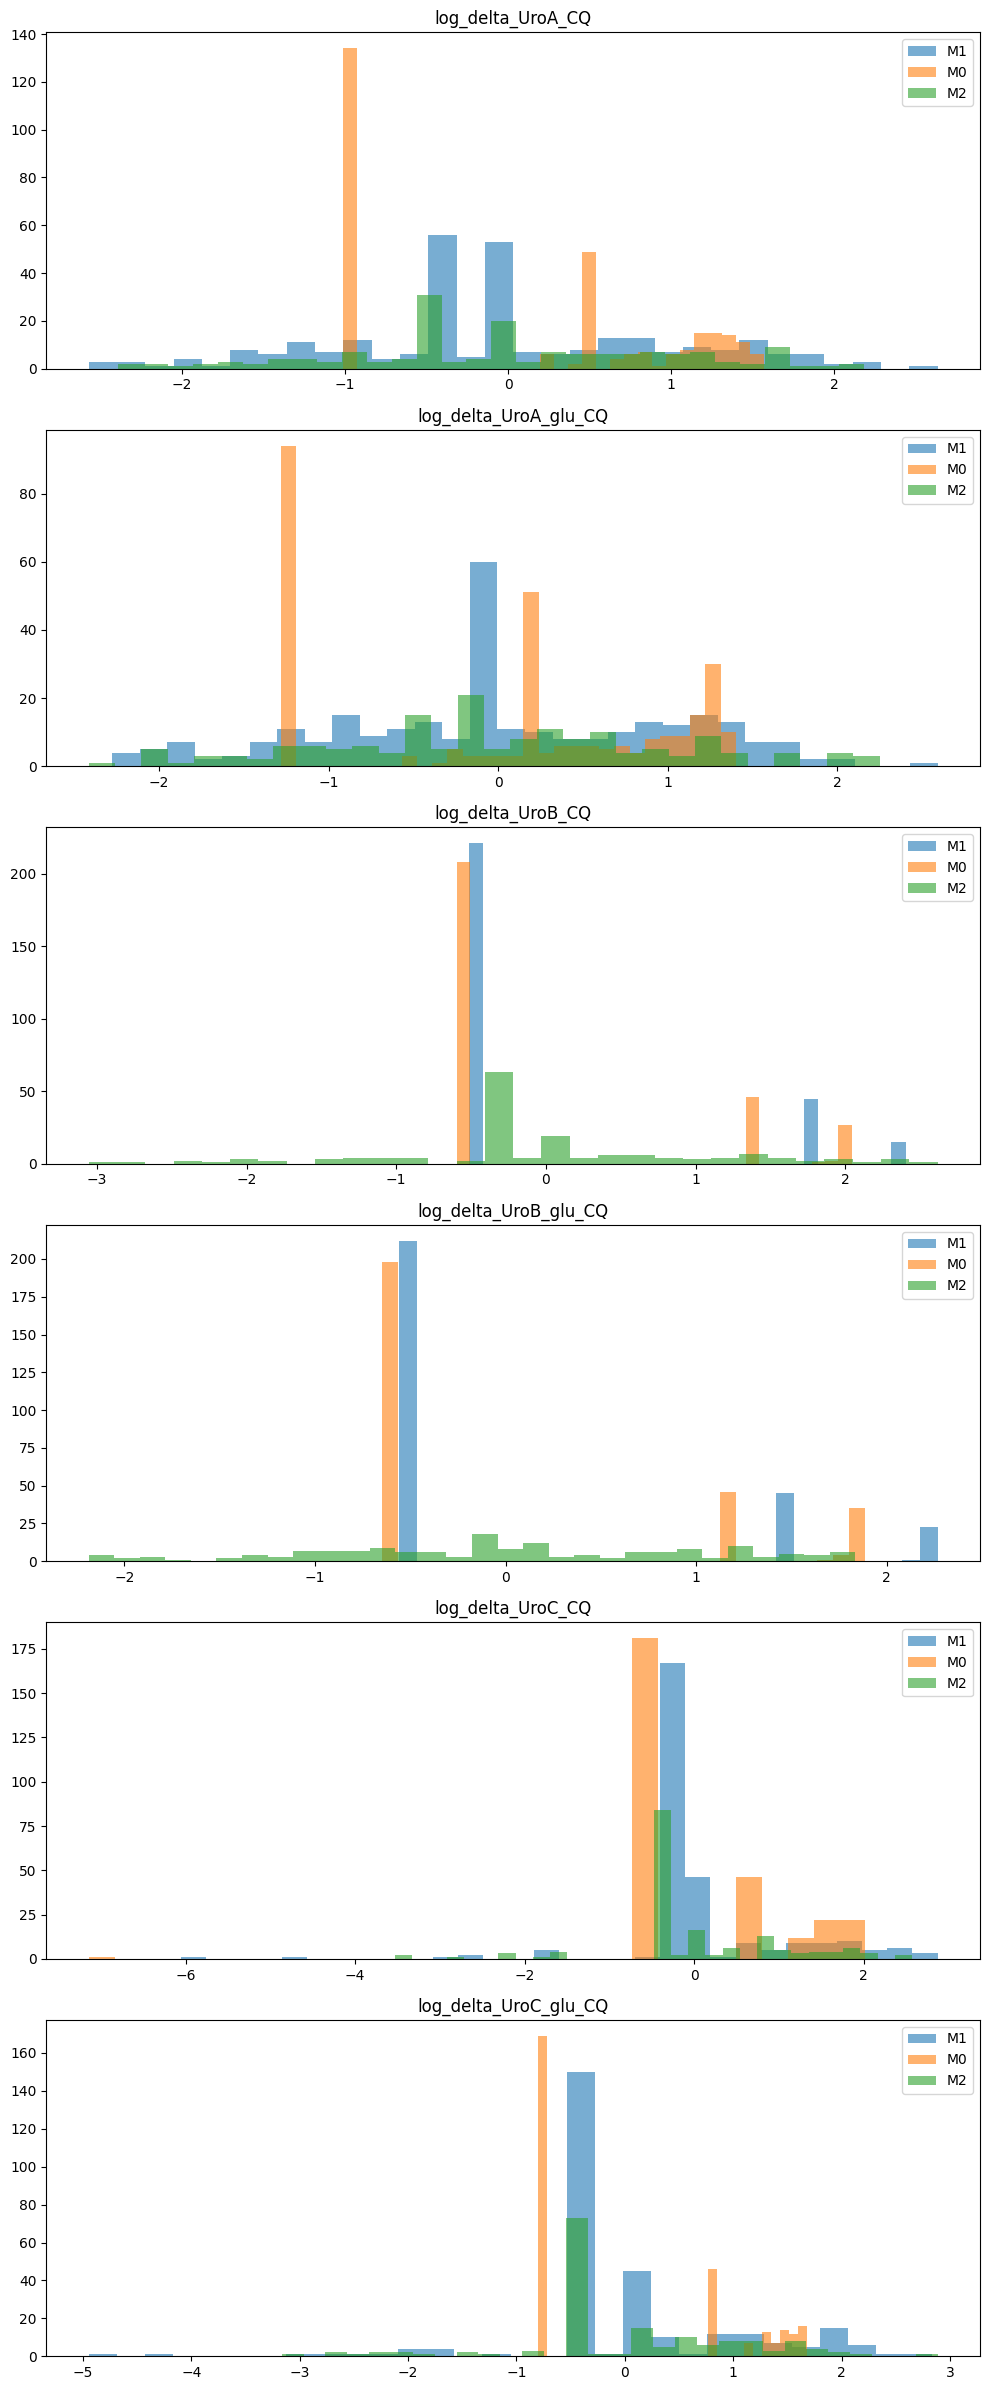

In [ ]:

fig, axes = plt.subplots(nrows=len(delta_cols), figsize=(10, 4 * len(delta_cols)))
if len(delta_cols) == 1:
    axes = [axes]
for i, col in enumerate(delta_cols):
    for mtype, df_t in transformed_by_metabotype.items():
        axes[i].hist(df_t[col], bins=30, alpha=0.6, label=f"M{mtype}")
    axes[i].set_title(col)
    axes[i].legend()
plt.tight_layout()
plt.show()


## Clasificación de Cambios Cognitivos por Dominio y Metabotipo

In [ ]:

def categorize_change(val, threshold=0.25):
    if val > threshold:
        return 1
    elif val < -threshold:
        return -1
    else:
        return 0

baseline_features = [
    "Composite_MemoryMBASELINE", "Composite_LanguageMBASELINE", "Composite_PerceptionMBASELINE",
    "Composite_FrontalMBASELINE", "Composite_EEFFMBASELINE", "Composite_SpeedMBASELINE",
    "Composite_GlobalBASELINE"
]

delta_features = [col for col in df.columns if col.startswith("log_delta_")]
meta_features = ["Metabotype_2"]
features = baseline_features + delta_features + meta_features

target_vars = [
    "Composite_MemoryMCHANGE", "Composite_LanguageMCHANGE", "Composite_PerceptionMCHANGE",
    "Composite_FrontalMCHANGE", "Composite_EEFFMCHANGE", "Composite_SPEEDMCHANGE",
    "Composite_GlobalMCHANGE"
]

models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SVM": SVC()
}


In [ ]:

all_results = []
conf_matrices = {}

for metabotype in df["Metabotype_1"].dropna().unique():
    df_sub = df[df["Metabotype_1"] == metabotype].copy()
    X_raw = df_sub[features]
    X = pd.DataFrame(KNNImputer(n_neighbors=5).fit_transform(X_raw), columns=features)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    for target in target_vars:
        y_raw = df_sub[target].apply(categorize_change)
        valid = ~y_raw.isna()
        y = y_raw[valid].reset_index(drop=True)
        X_valid = X[valid.to_numpy()]

        for model_name, model in models.items():
            if len(set(y)) < 2:
                continue
            scores = cross_val_score(model, X_valid, y, cv=5, scoring='f1_macro')
            model.fit(X_valid, y)
            y_pred = model.predict(X_valid)
            conf_matrices[(metabotype, target, model_name)] = confusion_matrix(y, y_pred)
            all_results.append({
                "Metabotype_1": int(metabotype),
                "Target": target,
                "Model": model_name,
                "F1_macro (mean)": scores.mean(),
                "F1_macro (std)": scores.std()
            })

results_df = pd.DataFrame(all_results)
results_df


,Metabotype_1,Target,Model,F1_macro (mean),F1_macro (std)
0,1,Composite_MemoryMCHANGE,RandomForest,0.380248,0.037175
1,1,Composite_MemoryMCHANGE,GradientBoosting,0.394418,0.081372
2,1,Composite_MemoryMCHANGE,LogisticRegression,0.351924,0.036931
3,1,Composite_MemoryMCHANGE,SVM,0.333569,0.020600
4,1,Composite_LanguageMCHANGE,RandomForest,0.412068,0.068039
...,...,...,...,...,...
79,2,Composite_SPEEDMCHANGE,SVM,0.329759,0.060102
80,2,Composite_GlobalMCHANGE,RandomForest,0.266958,0.011252
81,2,Composite_GlobalMCHANGE,GradientBoosting,0.379185,0.063863
82,2,Composite_GlobalMCHANGE,LogisticRegression,0.357004,0.058621


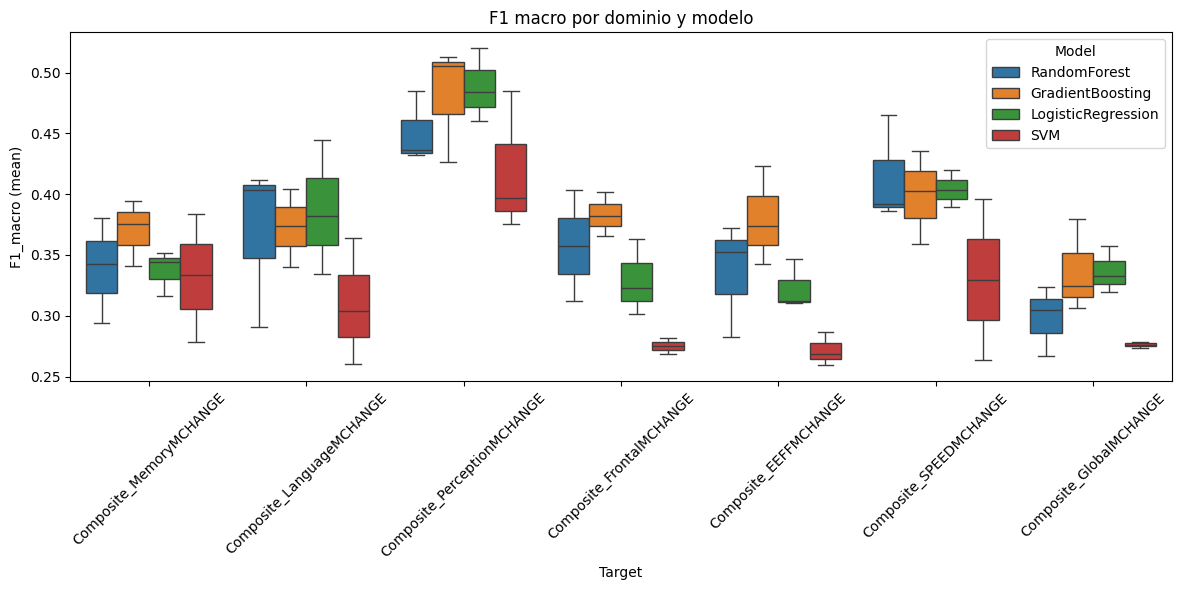

In [ ]:

plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x="Target", y="F1_macro (mean)", hue="Model")
plt.xticks(rotation=45)
plt.title("F1 macro por dominio y modelo")
plt.tight_layout()
plt.show()


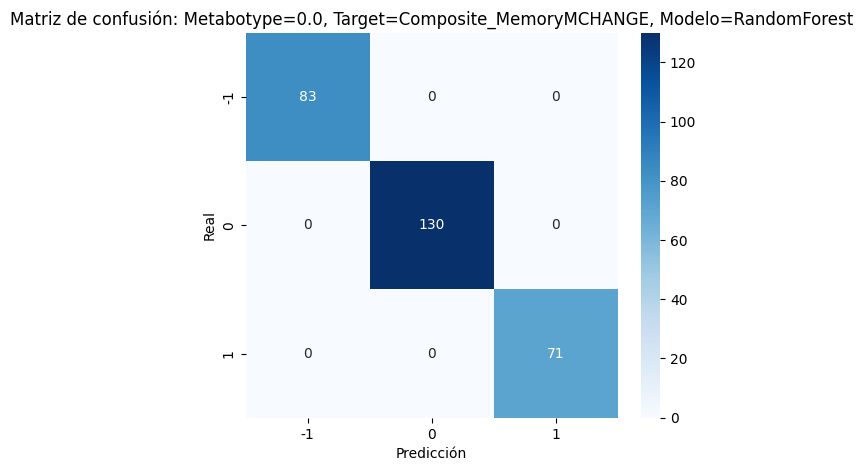

In [ ]:

best_key = max(conf_matrices.keys(), key=lambda k: conf_matrices[k].trace())
matrix = conf_matrices[best_key]
labels = [-1, 0, 1]

plt.figure(figsize=(6, 5))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title(f"Matriz de confusión: Metabotype={best_key[0]}, Target={best_key[1]}, Modelo={best_key[2]}")
plt.show()


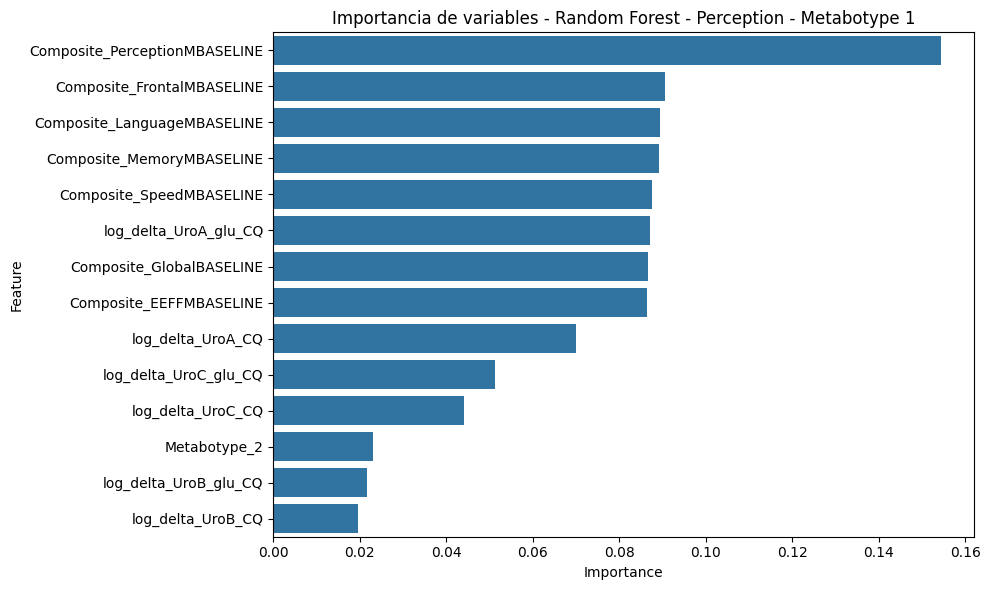

In [ ]:

rf_perception = RandomForestClassifier(n_estimators=100, random_state=42)
df_sub = df[df["Metabotype_1"] == 1]
X_rf = df_sub[features]
X_rf = pd.DataFrame(KNNImputer(n_neighbors=5).fit_transform(X_rf), columns=features)
X_rf = StandardScaler().fit_transform(X_rf)
y_rf = df_sub["Composite_PerceptionMCHANGE"].apply(categorize_change)
valid = ~y_rf.isna()
y_rf = y_rf[valid].reset_index(drop=True)
X_rf = X_rf[valid.to_numpy()]
rf_perception.fit(X_rf, y_rf)

importances = rf_perception.feature_importances_
feat_df = pd.DataFrame({"Feature": features, "Importance": importances}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df.head(15), x="Importance", y="Feature")
plt.title("Importancia de variables - Random Forest - Perception - Metabotype 1")
plt.tight_layout()
plt.show()


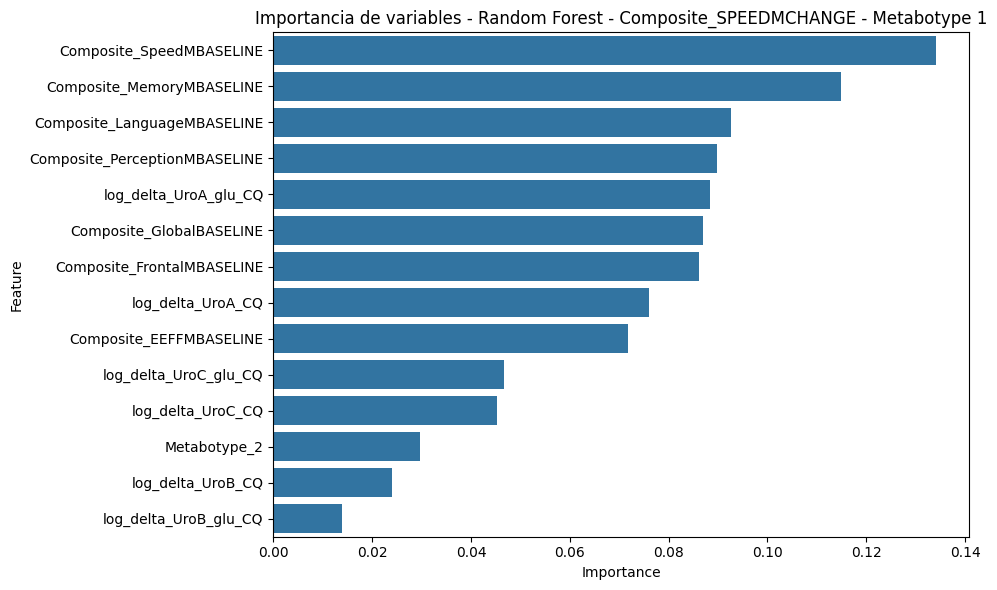

In [ ]:
# Parámetros que puedes cambiar
target = "Composite_SPEEDMCHANGE"
metabotype = 1

# Entrenamiento del modelo para ese dominio y subgrupo
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

df_sub = df[df["Metabotype_1"] == metabotype]
X_rf = df_sub[features]
X_rf = pd.DataFrame(KNNImputer(n_neighbors=5).fit_transform(X_rf), columns=features)
X_rf = StandardScaler().fit_transform(X_rf)

y_rf = df_sub[target].apply(categorize_change)
valid = ~y_rf.isna()
y_rf = y_rf[valid].reset_index(drop=True)
X_rf = X_rf[valid.to_numpy()]

rf_model.fit(X_rf, y_rf)

importances = rf_model.feature_importances_
feat_df = pd.DataFrame({"Feature": features, "Importance": importances}).sort_values("Importance", ascending=False)

# Gráfico
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df.head(15), x="Importance", y="Feature")
plt.title(f"Importancia de variables - Random Forest - {target} - Metabotype {metabotype}")
plt.tight_layout()
plt.show()


### Conclusiones

Durante el desarrollo de este análisis, exploramos una variedad de algoritmos de clasificación para abordar un problema multiclase relacionado con los cambios en el desempeño cognitivo. Observamos que algunos modelos, como Random Forest y Gradient Boosting, obtuvieron resultados significativamente superiores al resto, lo que sugiere que ciertas estructuras de aprendizaje no lineales se adaptan mejor a este tipo de datos.

A pesar de estos avances, identificamos oportunidades importantes de mejora. Por ejemplo, sería recomendable incluir una tabla comparativa más completa entre modelos, que incluya además del accuracy, otras métricas relevantes como la precisión, el recall y el F1-score, junto con el tiempo de entrenamiento de cada modelo. Esta comparación facilitaría la toma de decisiones más informadas sobre qué modelos optimizar.

Además, aún no se ha realizado un ajuste fino de hiperparámetros mediante herramientas como GridSearchCV. Esta etapa sería clave para mejorar la capacidad de generalización de los modelos y evitar decisiones basadas en configuraciones por defecto, todavía no se ha seleccionado formalmente un modelo final, ni se ha justificado esa elección en función de criterios como interpretabilidad, complejidad computacional o relevancia para el contexto de aplicación.

El trabajo desarrollado hasta este punto representa una base sólida. Con algunos ajustes adicionales, como la comparación detallada, el ajuste de hiperparámetros y la elección razonada del modelo final, el análisis podría cumplir completamente con los criterios de calidad esperados.

